<a href="https://colab.research.google.com/github/RodrigodeFeo/8DTS/blob/main/Plataformas_Azure_Treino_Fora_Azure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup



<font color="red">Caso apareça um botão como esse durante o setup, deve ser necessário reiniciar o "Runtime"</font>


Pode ser feito clicando no botão ou pelo menu do Colab.

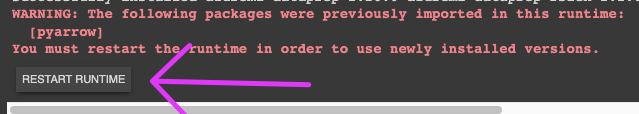

In [ ]:
!git clone https://github.com/elthonf/azure-ml.git

In [ ]:
!pip install joblib~=1.2.0

In [ ]:
!pip install scikit-learn~=1.1.0
#!pip install scikit-learn~=1.0.0

In [ ]:
!pip install azureml-core

In [ ]:
#!pip install azureml-dataprep
!pip install azureml-dataset-runtime

In [ ]:
!mkdir modelo
!mkdir modelo/ambiente
!mkdir dadostreino
!pip list > modelo/ambiente/bibliotecas.txt
!pip freeze > modelo/ambiente/requirements.txt
!python --version > modelo/ambiente/python_version.txt

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, ConfusionMatrixDisplay, classification_report
import sys, math, random, json, sklearn, joblib, uuid, os
from azureml.core import Experiment, Workspace, Dataset, Model

In [ ]:
sklearn.__version__

Funções auxiliares

In [ ]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

In [ ]:
def describe(df):
    return pd.concat([df.describe(include="all", percentiles=[.1, .2, .25, .3, .4, .5, .6, .7, .75, .8, .9]).T,
                      df.dtypes.rename('dtypes'),
                      #df.mad().rename('mad'),
                      #df.skew().rename('skew'),
                      #df.kurt().rename('kurt'),
                      df.nunique().rename('nunique'),
                     ], axis=1)
def describe_cols(df, df_summary=None):
    if df_summary is None:
        df_summary = describe(df)
    ret = {}
    for i, row in df_summary.iterrows():
        if row["nunique"] <= 100:
            ret[i] = {"classes" : json.loads( df.groupby([i]).size().to_json() ) }
        elif np.issubdtype(row["dtypes"], np.number):
            _h = np.histogram(df[i])
            ret[i] = {"hist": list(_h[0]),
                      "bin_edges": list(_h[1])}
        else:
            ret[i] = {}
    return ret

# Conexão com ML Studio

In [ ]:
#Trocar os códigos abaixo pelos da sua instância!
subscription_id = 'f7c59076-7117-4e47-bf2a-86f2ac61b485'
resource_group = 'Santander'
workspace_name = 'AreaParaOSantander'

workspace = Workspace(subscription_id, resource_group, workspace_name)

# Carga de dados
Inclui métricas dos dados / metadados

In [ ]:
mydf = pd.read_csv('azure-ml/datasets/statistical/BaseDefault01.csv')
mydf.head()

In [ ]:
dataset_name, dataset_version = 'Risco-De-Credito', None
try:
  dataset = Dataset.get_by_name(workspace, name=dataset_name)
  dataset_version = dataset.version
  df = dataset.to_pandas_dataframe()
  display( df.head() )
except:
  print("Dataset não encontrado")

In [ ]:
mydf.to_csv("./dadostreino/original_data.csv")

In [ ]:
mydf_metadata = describe(mydf)
#mydf_metadata.to_json("./dadostreino/metadata.json", indent=4, orient='index')
mydf_metadata.to_markdown("./dadostreino/metadata.md")
mydf_metadata.to_csv("./dadostreino/metadata.csv")
mydf_metadata

In [ ]:
# gera arquivo de quantidade por classes
mycounts = describe_cols(mydf, mydf_metadata)

with open('dadostreino/classes.json', 'w', encoding='utf-8') as f:
    json.dump(mycounts, f, ensure_ascii=False, indent=4, cls=NpEncoder)

In [ ]:
display(mycounts)

# Treinamento

Identifica no dataset as variáveis independentes e a variavel alvo

In [ ]:
targetcol = 'default'
y = mydf[targetcol]

Cria experimento

In [ ]:
experiment = Experiment(workspace=workspace, name="Experimento_MLStudio")

## Treina modelo 01 (Classificador)

Cria uma execução para o experimento

In [ ]:
myrunid = str(uuid.uuid1())
run = experiment.start_logging(run_id=myrunid,
                               display_name=f"My Run {myrunid} feito em aula",
                               outputs="modelo",
                               snapshot_directory="dadostreino")
run.log("Tipo", "Classificador")

In [ ]:
independentcols = ['renda', 'idade', 'etnia', 'sexo', 'casapropria', 'outrasrendas', 'estadocivil', 'escolaridade']
X = mydf[independentcols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)
clf = rfc(n_estimators=10)
clf.fit(X=X_train[independentcols], y=y_train)
clf.independentcols = independentcols

Avaliações e Logs

In [ ]:
clf_acuracia = clf.score(X=X_test[independentcols], y=y_test)
print("Modelo 01 (classificador), criado com acurácia de: [{0}]".format(clf_acuracia))
run.log("acuracia", clf_acuracia)

In [ ]:
#Demais logs (não serão comparados)
run.log("language", "python")
run.log("python", sys.version)
run.log("Versao sklearn", sklearn.__version__)
run.log("criterion", clf.criterion)
run.log("n_estimators", clf.n_estimators)
run.log("min_samples_leaf", clf.min_samples_leaf)
run.log("max_depth",  str(clf.max_depth))
run.log("dataset_name",  dataset_name)
run.log("dataset_version",  dataset_version)
run.log_list("Inputs", independentcols)

In [ ]:
#Exibe Matriz de confusão e grava em arquivo
display(f"Matriz de confusão do modelo:")
ConfusionMatrixDisplay.from_estimator(clf, X_test[independentcols], y_test).figure_.savefig('modelo/confusion_matrix.png')

In [ ]:
#Exibe Classification Report e grava em arquivo
c_report = classification_report(y_test, clf.predict(X_test[independentcols]))
print(f"Classification Report:\n{c_report}")
with open("modelo/classification_report.txt", "w") as text_file:
    text_file.write(c_report)

Exporta o modelo

Dica: Após a exportação, é possível consultar o modelo e demais artefatos pelo explorador de arquivos, ou com a instrução:

```
!ls -l modelo
```

In [ ]:
model_name = "modelo_bin.pkl"
filename = "modelo/" + model_name
joblib.dump(value=clf, filename=filename)
run.log("model_binary": filename)

Finaliza o experimento
Obs.:pode demorar alguns segundos/minutos para os arquivos da pasta "modelo" aparecerem no Azure ML Studio.

In [ ]:
run.complete()
run.wait_for_completion()
os.remove("./modelo/modelo_bin.pkl")
os.remove("./modelo/confusion_matrix.png")
os.remove("./modelo/classification_report.txt")

# Atividade 1 : Análise na Azure

Crie n modelos em experimentos para nosso problema de risco de crédito, e envie para a Azure. Em seguida, compare os resultados dentro da plataforma Azure.  

Cada experimento deve ter seus parâmetros alterados conforme vetores.  
Observe que o nomes dos parâmetros são respectivamente n_estimators, max_depth e min_samples_leaf.

|n_estimators|max_depth|min_samples_leaf|
|---|---|---|
|1|1|10|
|2|2|5|
|3|3|1|
|5|None|
|10|
|20|
|30|

Obs.:  
n = 8 $\times$ 4 $\times$ 3

In [ ]:
experiment = Experiment(workspace=workspace, name="Experimento_RiscoCredito")

In [ ]:
lst_n_estimators = [1, 2, 3, 5, 10, 20, 30]
lst_max_depth = [1, 2, 3, None]
lst_min_samples_leaf = [10, 5, 1]